CRNN : CNN + RNN
  - CNN : 이미지에서 특징을 추출하고 추출된 특징을 RNN에 넣어서 글자를 예측
  - CTC손실 : 결과가 다양한 방법으로 표현이 가능할때 사용하는 손실, 가능한 모든경로의 확률의 합을 확률로 표현


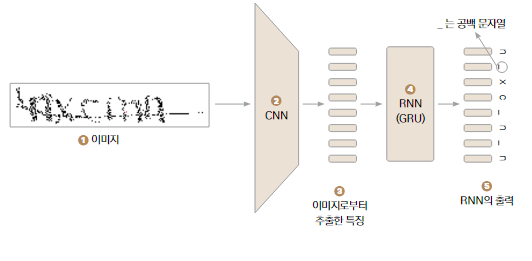

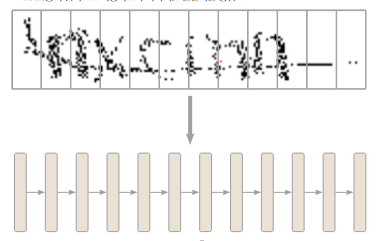

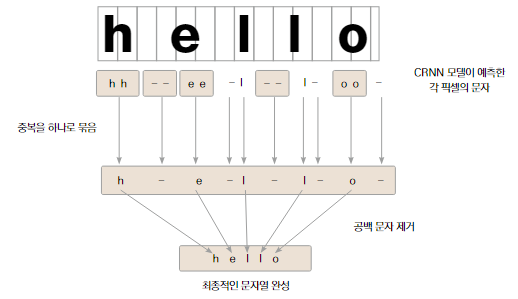

In [1]:
# ctc 손실

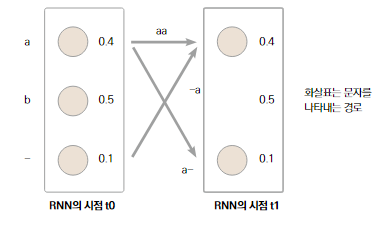

In [2]:
# aa 확률 : 0.4*0.4 \ 0.16
# a- 확률: 0.4*0.1 \ 0.04
# -a 확률: 0.1*0.4 \ 0.04
# 다 더하면.. 0.24의 확률 24%로 a를 타나내고 있음

In [3]:
# CTC 손실이 최소화  되도록 학습

In [ ]:
# 데이터  https://www.kaggle.com/datasets/fournierp/captcha-version-2-images

In [ ]:
!unzip '/content/drive/MyDrive/캡차/archive.zip'

In [19]:
import string
import matplotlib.pyplot as plt
import glob
import tqdm
from PIL import Image

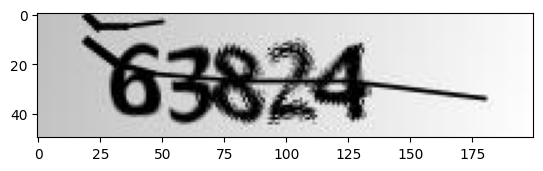

In [6]:
imgfiles = glob.glob("/content/samples/*.png")
imgfile =  Image.open(imgfiles[0])
plt.imshow(imgfile)
plt.show()

In [8]:
imgfiles[0]

'/content/samples/63824.png'

In [7]:
# png 파일은 rgb, 투명도를나타내는 알파채널이 있음

In [9]:
# 파일이름의 확장자를 제거.. ->정답
# 정답에 등장하는 모든 문자에대한 BOW를 생성
import numpy as np
from torch.utils.data.dataset import Dataset

In [15]:
def get_BOW(corpus):
  # 공백문자 <pad>를 0으로 설정
  BOW = {"<pad>" : 0}
  # 고유번호 추가
  for latter in corpus:
    if latter not in BOW:
      BOW[latter] = len(BOW.keys())
  return BOW

In [16]:
get_BOW(["aa",'bb','cc','bb'])

{'<pad>': 0, 'aa': 1, 'bb': 2, 'cc': 3}

In [25]:
# 데이터 셋
class Capcha(Dataset):
  def __init__(self,pth,train=True):
    # 소문자와 숫자만 정답으로 설정
    self.corpus = string.ascii_lowercase + string.digits  # abcdefghijklmnopqrstuvwxyz0123456789
    self.BOW = get_BOW(self.corpus)

    self.imgfiles = glob.glob(pth + "/*.png")

    self.train = train
    split_rate = int(len(self.imgfiles)*0.8)
    self.trainset = self.imgfiles[ : split_rate ]
    self.testset = self.imgfiles[split_rate : ]
  # 챕차의 문자를 고유 번호로 변경
  def get_seq(self, line):
    label = []
    for latter in line:
      label.append(self.BOW[latter])
    return label
  def __len__(self):
    if self.train:
      return len(self.imgfiles)
    else:
      return len(self.testset)
  def __getitem__(self, index):
    if self.train:
      # png파일을 rgb 파일로 변환
      data = Image.open(self.trainset[index]).convert("RGB")
      label = self.trainset[index].split("/")[-1]
      # 확장자 제거
      label = label.split('.')[0]
      data = np.array(data).astype(np.float32)
      # 파이토치 채녈이 가장 앞에 와야 함
      data = np.transpose(data,(2,0,1))
      label = np.array(label)
      return data, label
    else:
      data = Image.open(self.testset[index]).convert("RGB")
      label = self.testset[index].split("/")[-1]
      label = label.split('.')[0]
      label = self.get_seq(label)

      data = np.array(data).astype(np.float32)
      label = np.array(label)
      return data, label

In [ ]:
# Resnet 구조로 CNN 설계
# 캡차는 기존 이미지크기와 다르게 가로픽셀이 세로보다 많은 직사각형--> 커널의 모양도 가로의 길이가 더 크게
# 최종적으로  RNN의 입력으로 들어가야 함 세로방향의 픽셀이 1개만 존재

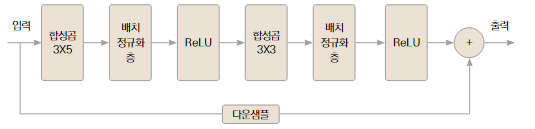

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# 3x5 크기의 커널을 사용
# 3x5는 긴 형태의 객체를 탐지하는데 도움

In [29]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=(3,5), stride=(2,1)):
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride)
    self.conv2 = nn.Conv2d(in_channels = in_channels,out_channels=out_channels,kernel_size=(3,3),padding=1)
    self.downsample = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride)
    self.bn = nn.BatchNorm2d(num_features=out_channels)
    self.relu = nn.ReLU()
  def forward(self, x):
    x_ = x
    x = self.relu(self.bn(self.conv1(x)))
    x = self.downsample(self.bn(self.conv2(x)))
    x += x_
    x = self.relu(x)
    return x

In [ ]:
# CNN으로 부터 얻은 특징은 GRU에 입력하는건 불가능
# GRU는 픽셀간의 순서 정보를 학습
# 파이토치는 이미지를 처리할때 채널 정보가 가장 앞에 온다 - > 채널 정보와 픽셀의 순서를 변경
# GRU의 결과에서 얻어진 텐서는 MLP층을 통해 어떤 글자인지 분류

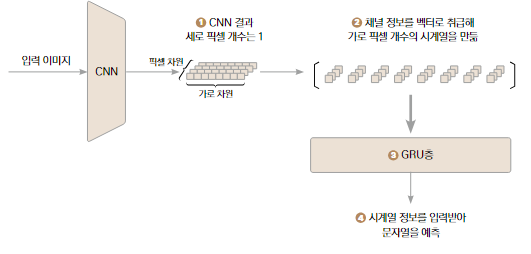

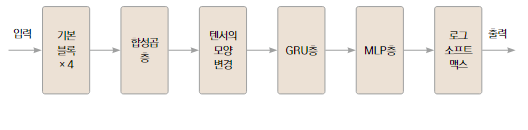

In [23]:
class CRNN(nn.Module):
  def __init__(self, output_size):
    super(CRNN, self).__init__()
    # CNN층
    self.c1 = BasicBlock(in_channels=3, out_channels=64)
    self.c2 = BasicBlock(in_channels=64, out_channels=64)
    self.c3 = BasicBlock(in_channels=64, out_channels=64)
    self.c4 = BasicBlock(in_channels=64, out_channels=64)
    self.c5 = nn.Conv2d(in_channels=64, out_channels=64,kernel_size=(2,5))

    # GRU
    self.gru = nn.GRU(64,64,batch_first=False)

    # 분류기 MLP층
    self.fc1 = nn.Linear(in_features=64, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=output_size)
    self.relu = nn.ReLU()
  def forward(self, x):
    # 입력텐서의 모양 (b,3,50,200)
    x = self.c1(x)
    x = self.c2(x)
    x = self.c3(x)
    x = self.c4(x)
    x = self.c5(x)
    # 텐서 모양은 (b,64,1,180)
    # (b,64,180)
    x = x.view(x.shape[0],64,-1)
    # (180,b,64)
    x = x.permute(2,0,1)
    # gru로 시계열 정보 추출
    x, _ = self.gru(x)  # 은닉상태, 예측값

    # MLP층으로 각 픽셀 분류
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    # CTC손실 계산을 위해 로그 소프트 맥스 이용
    x = F.log_softmax(x,dim=-1)
    return x

In [30]:
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = Capcha('/content/samples')
loader = DataLoader(dataset,batch_size=8)
model = CRNN(output_size=len(dataset.BOW)).to(device)
optim = Adam(model.parameters())